# Introduction
This notebook is aimed to host data from the Titanic dataset for Kaggle's competition. We aimed to analyze and predict which passengers from the Titanic will survive.

### Imports
Import libraries establish settings.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis
import pingouin as pg

# set matplotlib parameters


C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\sebas\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Analysis/Modeling

## Import data

In [2]:
# path to the file
path = "train.csv"

# import csv
train = pd.read_csv(path)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing values

Let's explore what kind of data the Dataset holds.

We have numeric and categorical data. Most of the columns contains non-null values, although we can see that missing values are found for Age, Cabin and some for Embarked. Specifically, we have 177 NaN values in Age, 687 in Cabin and 2 in Embarked.


For this, we would adopt some strategies. 

* First, we will first explore if there are differences between "Pclass" in "Age". In case there are statistically significant differences, we will impute the NaN values in "Age" computing the mean value for each "Pclass" group.


* Second, it seems that NaN values for "Cabin" should correspond to those in third class that do not have a cabin assigned. In any case, we will first see if for "Cabin" we only have "3" as unique value.


* Third, we will try to find some information in the Dataset to impute missing values in "Embarked". We will try to seach for that on the internet in case we do not success.

In [3]:
# DataFrame information
train.info()

# missing values in Age, Cabin and Embarked
pd.DataFrame(data=train[["Age", "Cabin", "Embarked"]].isnull().sum(), columns=["Missing values"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Missing values
Age,177
Cabin,687
Embarked,2


Let's explore descriptive statistics for numerical data. We can see that we have a minimum Age of 0.42, that should correspond to the age of an infant. Also, we see that Pclass is between 1 and 3, so no unexpected values in that column based on unique values.

In [4]:
# descriptive statistics for numeric variables
train[["Age", "Fare", "Pclass"]].describe()

# unique values in Pclass
print("We have these unique values in Pclass column:", sorted(list(train["Pclass"].unique())))

We have these unique values in Pclass column: [1, 2, 3]


Now, we will test if there are statistically significant differences in "Age" based on "Pclass". From the ANOVA, we see that there is a statistiaclly significant difference, so we should replace NaN values for each "Pclass" independently.

In [5]:
# descriptive statistics by Pclass
display(train.groupby(["Pclass"])["Age"].describe().T)

# ANOVA
pg.anova(data=train[["Pclass", "Age"]], dv="Age", between="Pclass", detailed=False)

Pclass,1,2,3
count,186.000000,173.000000,355.000000
mean,38.233441,29.877630,25.140620
std,14.802856,14.001077,12.495398
min,0.920000,0.670000,0.420000
25%,27.000000,23.000000,18.000000
50%,37.000000,29.000000,24.000000
75%,49.000000,36.000000,32.000000
max,80.000000,70.000000,74.000000


,Source,ddof1,ddof2,F,p-unc,np2
0,Pclass,2,711,57.443484,7.487984e-24,0.139107


From the distribution of age we can see that older ages are more common along the first class. This makes sense, as in the first class we should have found people from a high socioeconomic background, hence they were able to afford a better lifestyle and better health care. On the other hand, we can see that the upper boundary of the interquartile range is around 55 years of age, and a few outliers above that.

C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\sebas\Anaconda3\lib\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


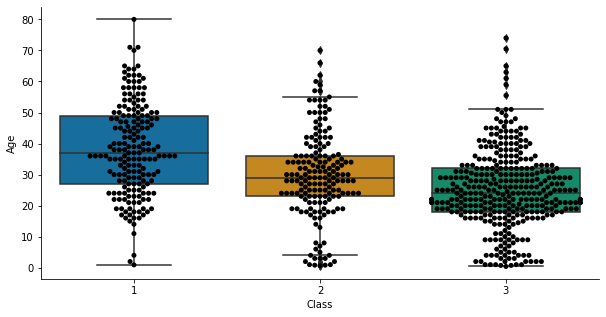

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=train["Pclass"], y=train["Age"], palette="colorblind")
sns.swarmplot(x=train["Pclass"], y=train["Age"], color="black")
ax.set_xlabel("Class")
sns.despine()

Exploring the data, we have discovered that we cannot make an automatic replacement for "Cabin", as we have NaN values not only for third class, but for first and second too. Once discovered this, we will replace NaN values for third class with "T" in "Cabin", but for the others "Pclass" we will maintain NaN values.

According to online documentation, third class cabins were located at the lower levels of the ship, while second and first class were located in the upper floors.

In [8]:
# unique values of Pclass for missing values in Cabin
train[train["Cabin"].isnull()]["Pclass"].unique()

array([3, 2, 1], dtype=int64)

We couldn't gather any additional information based on "Ticket" or "Cabin" to replace missing values in "Embarked". However, looking for information on the Internet we found that Miss Amelie Icard traveled in the Titanic as maid to Mrs. Martha Evelyn, and they embarked in Southampton, so we will replace these missing values with an "S" for Southampton.

In [9]:
# rows for missing values in Embarked
display(train[train["Embarked"].isnull()])

# replace Embarked missing values
train.loc[(train["Cabin"] == "B28"), "Embarked"] = "S"
train[train["Cabin"] == "B28"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


## Feature engineering (create Custom Transformer for this)

The "Ticket" variable contains a lot of interesting information. We will try to extract more useful features splitting the ticket data into two, one variable including the first letters of the ticket as it seems to code something more specific. The other will contain the rest of the ticket information.

In [10]:
# empty DataFrame to contain the splitted information
empty = pd.DataFrame()

# split the data
empty = train["Ticket"].str.split(pat=' ', n=1, expand=True)

# rename the columns
empty.rename({0: "Ticket_L", 1: "Ticket_N"}, axis=1, inplace=True)

# merge into the train DataFrame the splitted data
train = train.merge(empty, left_on=train.index, right_on=empty.index).drop(columns='key_0')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,211536,None
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,112053,None
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,W./C.,6607
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,111369,None


Exploring values in third class we have discovered that there are also some passengers that have a double letter on their Cabin, like Passenger 716 (Mr. Peter Andreas) which Cabin is F G73. It seems that he was located on F Deck, but section G. In this case we will separate this also, we will create a column for section.

First, let's create a regex expression just to extract the first and second letter of "Cabin", otherwise, it will indicate NaN in case the expression is not matched. We will merge both DataFrames in train and fill NaN values in "Section" with values in "Deck", as there is only one letter that indicated the same Deck and Section.

In [11]:
train[(train["Pclass"] == 3) & (train["Cabin"].notnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,PP,9549
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,348123,None
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,2668,None
205,206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,347054,None
251,252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,347054,None
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S,PP,9549
429,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S,SOTON/O.Q.,392078
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.6500,F G63,S,348121,None
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S,348124,None
751,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S,392096,None


In [12]:
def deck_section(df):
    """
    Extract Section letter from those cases in which Cabin
    indicated Deck and Section. If there is no Section letter,
    the Section value will be fill with the Deck value.
    """
    # extract the Deck from Cabin
    df["Deck"] = df["Cabin"].str.slice(start=0, stop=1)
    # create regex pattern
    pattern = r"^(\D)(\s)(\D)"
    # extract the letters where the expression is matched, otherwise NaN. Rename columns so they are informative
    t_df = df["Cabin"].str.extract(pattern).rename(columns={0: "Deck", 1: "whitespace", 2: "Section"})
    # check case 715 where there is one letter for Deck and another for Section
    # concatenate DataFrame and Series
    df = pd.concat([df, t_df["Section"]], axis=1, join="inner")
    # where section is null, replace with deck value
    df["Section"] = np.where(df["Section"].isnull(), df["Deck"], df["Section"])
    
    return df

train = deck_section(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803,None,C,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,211536,None,NaN,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,112053,None,B,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,W./C.,6607,NaN,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,111369,None,C,C


We can see that there are some third class passengers that have a Cabin number are located in floors F or E, not G. This is interesting... why do we find this? It seems that Cabins in the Titanic were not evenly distributed by floors, as different class Cabins could be located on the same floor. We can also see that there is a T boat deck, and some 1st class cabins were located at E deck.

Looking for information on the internet, we have found that the letter of the Cabin designated the range fo floors that covered. So in order to simplify this feature, we will also store the deck letter in a separate column.

In [13]:
print("Let's check how many Decks occupied each class:")
display(train.groupby(["Pclass"])["Deck"].unique())

print("\nThere is one 1st class passengger on Deck T:")
display(train[train["Deck"] == "T"])

Let's check how many Decks occupied each class:


Pclass
1    [C, E, A, nan, B, D, T]
2             [nan, D, F, E]
3             [nan, G, F, E]
Name: Deck, dtype: object


There is one 1st class passengger on Deck T:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_L,Ticket_N,Deck,Section
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,113784,None,T,T


We still have quite a lot of missing values for "Cabin" in 3rd class passengers, so both Deck and Section will be also empty. Looking for information most of the 3rd class cabins were located in F deck and some in G deck, so we can fill the missing values in Cabin for 3rd class passengers with F for Deck and Section. This is also the most common value of the non missing values in 3rd class as we can see in the plot. Interestingly, we also found that the Titanic was designed to avoid classed to mix, with gates usually closed for this purpose.

For 2nd class, most of the Cabins were located at E deck, so we will replace missing values for this class with an E for Deck and Section. In the plot we see that the most common Deck for 2nd class is D and E.

Finally, for 1st class the most common value is C deck, folowed by B.

In general, we will create a Custom Imputer to replace missing values in Deck and Section with the Deck with the higher number of passengers by Class.


Number of passengers by Class with missing values in Cabin:


,Pclass,Cabin
0,1,40
1,2,168
2,3,479


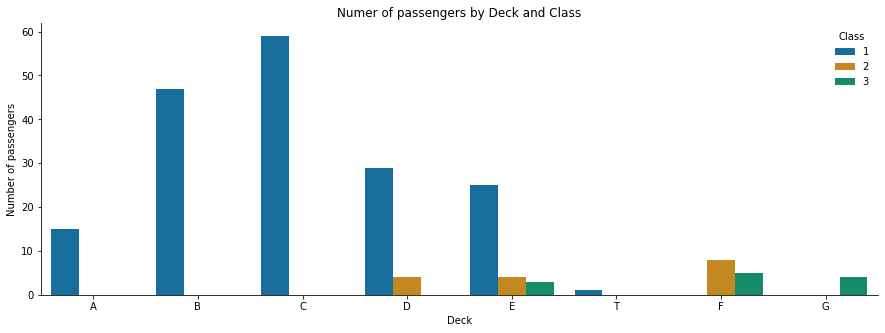

In [19]:
print("\nNumber of passengers by Class with missing values in Cabin:")
display(pd.DataFrame(data=train.groupby(["Pclass"], as_index=False)["Cabin"].apply(lambda x: x.isnull().sum())))

missing_class_deck = train.groupby(["Pclass", "Deck"], as_index=False)["PassengerId"].count()
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="Deck", y="PassengerId", hue="Pclass", data=missing_class_deck, palette="colorblind")
sns.despine()
ax.set_ylabel("Number of passengers")
ax.set_title("Numer of passengers by Deck and Class")
ax.legend(title="Class", frameon=False)
plt.show()

Let's create a the Custom Transformers, so we can apply it to the test dataset in a Pipeline. We can always check model fitting applying only certain transformers.

In [118]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.mean_age_by_class = {}
        print("Transforming data. In the AgeImputer init method: ")

    def fit(self, X, y=None):
        self.mean_age_by_class = X.groupby(["Pclass"])["Age"].mean()

        return self

    def transform(self, X, y=None):
        # apply values based on dictionaries 
        for pclass, mean_age in self.mean_age_by_class.items():           
            X.loc[((X["Age"].isnull()) & (X["Pclass"] == pclass)), "Age"] = mean_age
              
        return X

In [84]:
class DeckSectionImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.most_common_deck_first_class = {}
        self.most_common_deck_second_class = {}
        self.most_common_deck_third_class = {}
        print("Transforming data. In the DeckSectionImputer init method: ")

    def fit(self, X, y=None):
        temp_X = X.groupby(["Pclass", "Deck"], as_index=False)["PassengerId"].count()
        self.most_common_deck_first_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 1]["PassengerId"].max()].values[0]
        self.most_common_deck_second_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 2]["PassengerId"].max()].values[0]
        self.most_common_deck_third_class = temp_X["Deck"].loc[temp_X["PassengerId"] == temp_X.loc[df["Pclass"] == 3]["PassengerId"].max()].values[0]

        return self

    def transform(self, X, y=None):
        # first, second and third class Cabin null values replace in Deck
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 1)), "Deck"] = self.most_common_deck_first_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 2)), "Deck"] = self.most_common_deck_second_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 3)), "Deck"] = self.most_common_deck_third_class
        
        # first, second and third class Cabin null values replace in Section
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 1)), "Section"] = self.most_common_deck_first_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 2)), "Section"] = self.most_common_deck_second_class
        X.loc[((X["Cabin"].isnull()) & (X["Pclass"] == 3)), "Section"] = self.most_common_deck_third_class
        
        return X

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here